# Semantic Segmentation with Pretrained U-Net in Keras + Albumentations

## 🎯 Overview

This notebook demonstrates state-of-the-art semantic segmentation using:
- **Pretrained encoders** from ImageNet (ResNet50, ResNet34, MobileNetV2, VGG16)
- **U-Net decoder** architecture
- **Albumentations** for professional data augmentation
- **Automatic device detection** (CUDA GPU / Apple MPS / CPU)
- **Oxford-IIIT Pet dataset** (segmenting pets from background)

### ⚠️ Important for Apple Silicon (M1/M2/M3) Users:
To enable GPU acceleration via Metal Performance Shaders (MPS), you need:
```bash
pip install tensorflow-metal
```
Without `tensorflow-metal`, TensorFlow will use CPU only!

### Key Features:
✅ Transfer learning from ImageNet weights  
✅ Modern Keras 3.x implementation  
✅ Segmentation-optimized augmentations  
✅ Progress tracking with tqdm  
✅ Expected Dice score: 0.75-0.85 with just 10-15 epochs

### Why Pretrained Models?
- **Faster convergence**: 2-3x faster than training from scratch
- **Better performance**: Higher Dice scores with less data
- **Transfer learning**: Leverages ImageNet features for segmentation

## 📦 Installation

In [ ]:
# Install required packages
%pip install -q --upgrade albumentationsx tensorflow tensorflow-datasets keras matplotlib tqdm jupytext

Note: you may need to restart the kernel to use updated packages.


## 🔧 Imports and Setup

In [ ]:
import os
import platform
import warnings
from typing import Tuple
from dataclasses import dataclass

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import layers, models, optimizers, callbacks
import albumentations as A
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from tqdm import tqdm

# Display plots inline
%matplotlib inline

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Versions:")
print(f"  TensorFlow: {tf.__version__}")
print(f"  Keras: {keras.__version__}")
print(f"  Albumentations: {A.__version__}")
print(f"  Platform: {platform.system()} {platform.processor()}")

Versions:
  TensorFlow: 2.19.1
  Keras: 3.11.3
  Albumentations: 2.0.11
  Platform: Darwin arm


## 🖥️ Automatic Device Detection

Automatically detects and configures the best available compute device:

In [ ]:
def setup_device():
    """Setup and detect available compute device."""
    import platform
    system = platform.system()
    processor = platform.processor()
    
    # Check for GPU availability
    gpus = tf.config.list_physical_devices('GPU')
    
    if gpus:
        try:
            # Enable memory growth for GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            
            # Determine if it's CUDA or MPS
            if system == 'Darwin':
                print("✓ Apple Silicon MPS GPU detected")
                print("  TensorFlow will use Metal Performance Shaders")
                return 'MPS'
            else:
                device_name = f"CUDA GPU ({len(gpus)} device(s))"
                print(f"✓ Using {device_name}")
                try:
                    gpu_details = tf.config.experimental.get_device_details(gpus[0])
                    print(f"  GPU Name: {gpu_details.get('device_name', 'Unknown')}")
                except:
                    pass
                return 'GPU'
        except RuntimeError as e:
            print(f"GPU setup failed: {e}")
    
    # Check if on Apple Silicon without GPU detected
    if system == 'Darwin' and processor == 'arm':
        print("⚠️ Apple Silicon detected but MPS not available!")
        print("  To enable GPU acceleration, install tensorflow-metal:")
        print("  pip install tensorflow-metal")
        print("  Currently using CPU - training will be slower")
        return 'CPU'
    
    # Regular CPU fallback
    print("ℹ Using CPU (no GPU detected)")
    print("  Training will be slower. Consider using Google Colab with GPU.")
    return 'CPU'

# Detect and setup device
device_type = setup_device()

✓ Apple Silicon MPS GPU detected
  TensorFlow will use Metal Performance Shaders


## ⚙️ Configuration

Configure training parameters and model settings:

In [ ]:
@dataclass
class Config:
    """Configuration for training."""
    # Model
    backbone: str = 'resnet50'  # Options: 'resnet34', 'resnet50', 'mobilenetv2', 'vgg16'
    input_shape: Tuple[int, int, int] = (256, 256, 3)
    num_classes: int = 3  # Background, pet, border
    
    # Training
    batch_size: int = 8  # Adjust based on your GPU memory
    epochs: int = 10  # Pretrained models converge faster
    learning_rate: float = 5e-4
    
    # Dataset splits
    train_split: str = "train[:80%]"
    val_split: str = "train[80%:90%]"
    test_split: str = "train[90%:]"
    
    # Paths
    checkpoint_dir: str = 'checkpoints'

# Create configuration
config = Config()

print("Training Configuration:")
print(f"  Backbone: {config.backbone.upper()} (pretrained on ImageNet)")
print(f"  Input shape: {config.input_shape}")
print(f"  Batch size: {config.batch_size}")
print(f"  Epochs: {config.epochs}")
print(f"  Learning rate: {config.learning_rate}")
print(f"  Classes: {config.num_classes} (background, pet, border)")

# Adjust batch size based on device
if device_type == 'CPU':
    config.batch_size = 4
    print(f"  → Reduced batch size to {config.batch_size} for CPU")

Training Configuration:
  Backbone: RESNET50 (pretrained on ImageNet)
  Input shape: (256, 256, 3)
  Batch size: 8
  Epochs: 10
  Learning rate: 0.0005
  Classes: 3 (background, pet, border)


## 🏗️ U-Net Model Architecture

Build U-Net with pretrained ImageNet encoder:

In [ ]:
def build_unet_model(backbone_name: str, input_shape: Tuple, num_classes: int) -> keras.Model:
    """
    Build U-Net with pretrained backbone from ImageNet.
    
    The U-Net architecture consists of:
    1. Encoder: Pretrained backbone (ResNet, MobileNet, or VGG)
    2. Decoder: Transposed convolutions with skip connections
    3. Output: Softmax activation for multi-class segmentation
    """
    inputs = layers.Input(shape=input_shape)
    
    # Select pretrained encoder based on backbone choice
    if backbone_name == 'resnet34':
        print("Loading ResNet34 pretrained on ImageNet...")
        # Keras doesn't have ResNet34, so we use ResNet50V2
        encoder = tf.keras.applications.ResNet50V2(
            input_tensor=inputs,
            weights='imagenet',
            include_top=False
        )
        skip_layer_names = ['conv1_conv', 'conv2_block3_1_relu', 
                           'conv3_block4_1_relu', 'conv4_block6_1_relu']
        print("  (Using ResNet50V2 as ResNet34 equivalent)")
        
    elif backbone_name == 'resnet50':
        print("Loading ResNet50 pretrained on ImageNet...")
        encoder = tf.keras.applications.ResNet50(
            input_tensor=inputs,
            weights='imagenet',
            include_top=False
        )
        skip_layer_names = ['conv1_relu', 'conv2_block3_out', 
                           'conv3_block4_out', 'conv4_block6_out']
        
    elif backbone_name == 'mobilenetv2':
        print("Loading MobileNetV2 pretrained on ImageNet...")
        encoder = tf.keras.applications.MobileNetV2(
            input_tensor=inputs,
            weights='imagenet',
            include_top=False
        )
        skip_layer_names = ['block_1_expand_relu', 'block_3_expand_relu',
                           'block_6_expand_relu', 'block_13_expand_relu']
        
    elif backbone_name == 'vgg16':
        print("Loading VGG16 pretrained on ImageNet...")
        encoder = tf.keras.applications.VGG16(
            input_tensor=inputs,
            weights='imagenet',
            include_top=False
        )
        skip_layer_names = ['block1_pool', 'block2_pool', 
                           'block3_pool', 'block4_pool']
    else:
        raise ValueError(f"Unknown backbone: {backbone_name}")
    
    # Make encoder trainable for fine-tuning
    encoder.trainable = True
    
    # Get skip connections from encoder layers
    skip_layers = [encoder.get_layer(name).output for name in skip_layer_names]
    
    # Build U-Net decoder
    x = encoder.output
    decoder_filters = [256, 128, 64, 32]
    
    # Decoder blocks with skip connections
    for i, (skip, filters) in enumerate(zip(reversed(skip_layers), decoder_filters)):
        # Upsampling
        x = layers.Conv2DTranspose(filters, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        # Skip connection (concatenate)
        x = layers.Concatenate()([x, skip])
        
        # Double convolution block
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        # Dropout for regularization (except last block)
        if filters > 32:
            x = layers.Dropout(0.3)(x)
    
    # Final upsampling to match input resolution
    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Output layer with softmax for multi-class segmentation
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name=f'{backbone_name}_unet')
    print(f"Model created: {model.count_params():,} parameters")
    
    return model

## 🎨 Albumentations Augmentation Pipeline

Create segmentation-optimized augmentations with proper normalization:

In [ ]:
def create_augmentations(training: bool = True, backbone_name: str = 'resnet50'):
    """Create Albumentations pipeline optimized for segmentation.
    
    Key principles for segmentation augmentations:
    - Avoid aggressive geometric distortions (no ElasticTransform, GridDistortion)
    - Use conservative spatial transforms (mild rotation, scaling)
    - Apply color augmentations for robustness
    - Include normalization as the last step
    """
    
    # Get normalization parameters for each backbone
    if backbone_name in ['resnet34', 'resnet50', 'vgg16']:
        # Standard ImageNet normalization
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
    elif backbone_name == 'mobilenetv2':
        # MobileNetV2 normalizes to [-1, 1]
        mean = (0.5, 0.5, 0.5)
        std = (0.5, 0.5, 0.5)
    else:
        # Default ImageNet normalization
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
    
    if training:
        return A.Compose([
            # Spatial augmentations (conservative for segmentation)
            A.RandomCrop(height=256, width=256, pad_if_needed=True),
            A.HorizontalFlip(p=0.5),
            A.Affine(
                scale=(0.5, 2),  # Moderate scaling
                rotate=(-15, 15),  # Mild rotation
                balanced_scale=True,
                keep_ratio=True,
                p=0.5
            ),
            
            # Color augmentations
            A.ColorJitter(
                brightness=[0.8, 1.2],
                contrast=[0.8, 1.2],
                saturation=[0.8, 1.2],
                hue=[-0.5, 0.5],
                p=1
            ),  # Random brightness, contrast, saturation, hue
            
            # Noise and blur (mild)
            A.OneOf([
                A.GaussNoise(std_range=(0.1, 0.2), p=1),
                A.GaussianBlur(blur_limit=(3, 5), p=1),
            ], p=0.2),
            
            # Normalization (must be last!)
            A.Normalize(mean=mean, std=std),
        ], seed=137, strict=True)  # seed for reproducibility
    else:
        return A.Compose([
            # For validation/test: only resize and normalize
            A.CenterCrop(height=256, width=256, pad_if_needed=True, p=1),
            A.Normalize(mean=mean, std=std),
        ])

# Preview augmentation settings
print("Augmentation Pipeline:")
print("  Training:")
print("    - RandomCrop with padding")
print("    - HorizontalFlip (50%)")
print("    - Affine transforms (scale, rotate)")
print("    - ColorJitter")
print("    - Noise/Blur (20%)")
print("    - Normalization")
print("  Validation:")
print("    - CenterCrop with padding")
print("    - Normalization")

Augmentation Pipeline:
  Training:
    - RandomCrop with padding
    - HorizontalFlip (50%)
    - Affine transforms (scale, rotate)
    - ColorJitter
    - Noise/Blur (20%)
    - Normalization
  Validation:
    - CenterCrop with padding
    - Normalization


## 📊 Loss Functions and Metrics

Define segmentation-specific loss functions and metrics:

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1.0):
    """Dice coefficient metric for segmentation.
    
    Dice = 2 * |A ∩ B| / (|A| + |B|)
    Range: [0, 1] where 1 is perfect overlap
    """
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth))
    return dice

def dice_loss(y_true, y_pred):
    """Dice loss for training."""
    return 1.0 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    """Combined dice + categorical crossentropy loss.
    
    This combination helps with:
    - Dice: Handles class imbalance
    - CrossEntropy: Provides stable gradients
    """
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return dice_loss(y_true, y_pred) + tf.reduce_mean(cce)

class MeanIoU(tf.keras.metrics.MeanIoU):
    """Mean IoU metric for one-hot encoded masks."""
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert from one-hot to class indices
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

print("Loss and Metrics:")
print("  Loss: Combined (Dice + Categorical Crossentropy)")
print("  Metrics: Dice Coefficient, Mean IoU, Categorical Accuracy")

Loss and Metrics:
  Loss: Combined (Dice + Categorical Crossentropy)
  Metrics: Dice Coefficient, Mean IoU, Categorical Accuracy


## 📁 Dataset Loading

Load Oxford-IIIT Pet dataset for semantic segmentation:

In [ ]:
def load_dataset(config: Config):
    """Load Oxford-IIIT Pet dataset.
    
    The dataset contains:
    - Images of pets (cats and dogs)
    - Segmentation masks with 3 classes:
      0: Background
      1: Pet
      2: Border
    """
    print("Loading Oxford-IIIT Pet dataset...")
    print("This may take a few minutes on first run...")
    
    with tqdm(total=3, desc="Loading splits", unit="split") as pbar:
        (ds_train, ds_val, ds_test), ds_info = tfds.load(
            'oxford_iiit_pet',
            split=[config.train_split, config.val_split, config.test_split],
            with_info=True
        )
        pbar.update(3)
    
    print(f"\n✓ Dataset loaded successfully")
    print(f"  Train samples: {len(ds_train)}")
    print(f"  Val samples: {len(ds_val)}")
    print(f"  Test samples: {len(ds_test)}")
    
    return ds_train, ds_val, ds_test, ds_info

# Load the dataset
ds_train, ds_val, ds_test, ds_info = load_dataset(config)

Loading Oxford-IIIT Pet dataset...
This may take a few minutes on first run...



Loading splits: 100%|██████████| 3/3 [00:00<00:00, 41.73split/s]


✓ Dataset loaded successfully
  Train samples: 2944
  Val samples: 368
  Test samples: 368


## 🔄 Data Pipeline

Create efficient tf.data pipeline with augmentations:

In [ ]:
def preprocess_data(data_dict):
    """Preprocess raw data from TensorFlow datasets."""
    image = tf.cast(data_dict['image'], tf.float32)
    mask = data_dict['segmentation_mask']
    
    # Convert mask to int32 and ensure 2D
    mask = tf.cast(mask, tf.int32)
    mask = tf.squeeze(mask)  # Remove any extra dimensions
    
    # Remap mask values for cleaner classes
    # Original: 1=pet, 2=border, 3=background+border
    # New: 0=background, 1=pet, 2=border
    mask = tf.where(mask == 2, 0, mask)  # border -> background
    mask = tf.where(mask == 3, 2, mask)  # background+border -> border
    
    return image, mask

def create_data_pipeline(dataset, config: Config, augmentations, training: bool = True):
    """Create tf.data pipeline with augmentations."""
    
    def augment_fn(image, mask):
        """Apply Albumentations augmentations."""
        def aug(img, msk):
            img = img.numpy().astype(np.uint8)
            msk = msk.numpy().astype(np.uint8)
            
            # Apply augmentations (including normalization)
            augmented = augmentations(image=img, mask=msk)
            
            return augmented['image'], augmented['mask'].astype(np.int32)
        
        # Use tf.py_function to apply numpy-based augmentations
        aug_img, aug_mask = tf.py_function(
            aug, [image, mask], [tf.float32, tf.int32]
        )
        
        # Set shapes (required after py_function)
        aug_img.set_shape([config.input_shape[0], config.input_shape[1], 3])
        aug_mask.set_shape([config.input_shape[0], config.input_shape[1]])
        
        # One-hot encode the mask for multi-class segmentation
        aug_mask = tf.one_hot(aug_mask, config.num_classes)
        
        return aug_img, aug_mask
    
    # Build pipeline
    dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    if training:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(config.batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Create augmentation pipelines
train_aug = create_augmentations(training=True, backbone_name=config.backbone)
val_aug = create_augmentations(training=False, backbone_name=config.backbone)

# Create data pipelines
print("\nCreating data pipelines...")
train_dataset = create_data_pipeline(ds_train, config, train_aug, training=True)
val_dataset = create_data_pipeline(ds_val, config, val_aug, training=False)
test_dataset = create_data_pipeline(ds_test, config, val_aug, training=False)
print("✓ Data pipelines ready")


Creating data pipelines...
✓ Data pipelines ready


## 👀 Visualize Data Samples

Preview augmented training samples:

Training samples with augmentations:


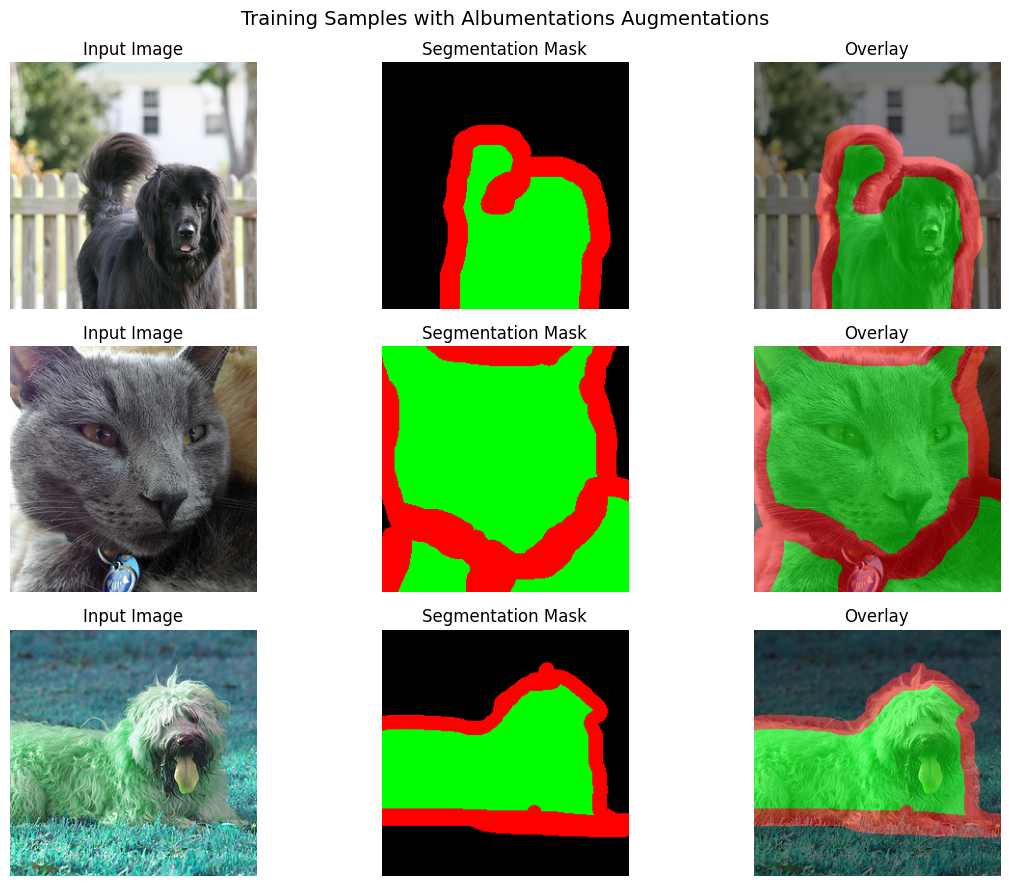

In [ ]:
def denormalize_image(img, backbone_name='resnet50'):
    """Properly denormalize image for visualization."""
    # Get normalization parameters
    if backbone_name in ['resnet34', 'resnet50', 'vgg16']:
        # Standard ImageNet normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
    elif backbone_name == 'mobilenetv2':
        # MobileNetV2 normalizes to [-1, 1]
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
    else:
        # Default ImageNet normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
    
    # Denormalize: x = (x_norm * std) + mean
    img_denorm = (img * std) + mean
    # Clip to [0, 1] range for valid image
    img_denorm = np.clip(img_denorm, 0, 1)
    return img_denorm

def visualize_samples(dataset, num_samples=3):
    """Visualize images and masks from dataset."""
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    # Get a batch of data
    for images, masks in dataset.take(1):
        for i in range(min(num_samples, images.shape[0])):
            # Properly denormalize image for visualization
            img = images[i].numpy()
            img = denormalize_image(img, config.backbone)
            
            # Convert one-hot mask to class indices
            mask = tf.argmax(masks[i], axis=-1).numpy()
            
            # Create colored mask for better visualization
            colored_mask = np.zeros((*mask.shape, 3))
            colored_mask[mask == 0] = [0, 0, 0]     # Background: black
            colored_mask[mask == 1] = [0, 1, 0]     # Pet: green
            colored_mask[mask == 2] = [1, 0, 0]     # Border: red
            
            # Plot image
            axes[i, 0].imshow(img)
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis('off')
            
            # Plot mask
            axes[i, 1].imshow(colored_mask)
            axes[i, 1].set_title("Segmentation Mask")
            axes[i, 1].axis('off')
            
            # Plot overlay
            axes[i, 2].imshow(img)
            axes[i, 2].imshow(colored_mask, alpha=0.5)
            axes[i, 2].set_title("Overlay")
            axes[i, 2].axis('off')
    
    plt.suptitle("Training Samples with Albumentations Augmentations", fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Training samples with augmentations:")
visualize_samples(train_dataset, num_samples=3)

## 🚀 Build and Compile Model

In [ ]:
# Build the model
print(f"Building {config.backbone.upper()} U-Net...\n")
model = build_unet_model(config.backbone, config.input_shape, config.num_classes)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=config.learning_rate),
    loss=combined_loss,
    metrics=[
        dice_coefficient,
        MeanIoU(num_classes=config.num_classes, name='mean_iou'),
        'categorical_accuracy'
    ]
)

print("\n📊 Model Summary:")
print(f"  Architecture: U-Net with {config.backbone.upper()} encoder")
print(f"  Total parameters: {model.count_params():,}")
print(f"  Loss: Combined (Dice + Categorical Crossentropy)")
print(f"  Optimizer: Adam (lr={config.learning_rate})")

Building RESNET50 U-Net...

Loading ResNet50 pretrained on ImageNet...
Model created: 33,387,043 parameters

📊 Model Summary:
  Architecture: U-Net with RESNET50 encoder
  Total parameters: 33,387,043
  Loss: Combined (Dice + Categorical Crossentropy)
  Optimizer: Adam (lr=0.0005)


## 🏋️ Training

Train the model with callbacks for monitoring and early stopping:

In [ ]:
# Setup callbacks
os.makedirs(config.checkpoint_dir, exist_ok=True)

checkpoint = callbacks.ModelCheckpoint(
    filepath=os.path.join(config.checkpoint_dir, f'best_{config.backbone}_unet.keras'),
    monitor='val_dice_coefficient',
    mode='max',
    save_best_only=True,
    verbose=0
)

early_stop = callbacks.EarlyStopping(
    monitor='val_dice_coefficient',
    mode='max',
    patience=7,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_dice_coefficient',
    mode='max',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=0
)

# Create tqdm callback for progress bars
tqdm_callback = TqdmCallback(verbose=2, leave=True)

# Train the model
print(f"\n🚂 Starting training for {config.epochs} epochs...")
print(f"   Backbone: {config.backbone.upper()} (pretrained)")
print(f"   Batch size: {config.batch_size}")
print(f"   Learning rate: {config.learning_rate}\n")

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=config.epochs,
    callbacks=[checkpoint, early_stop, reduce_lr, tqdm_callback],
    verbose=0  # Disable default progress bar (using tqdm instead)
)

print("\n✅ Training complete!")

# Print best metrics
best_dice = max(history.history['val_dice_coefficient'])
best_iou = max(history.history['val_mean_iou'])
print(f"\n📊 Best validation metrics:")
print(f"   Dice coefficient: {best_dice:.4f}")
print(f"   Mean IoU: {best_iou:.4f}")


🚂 Starting training for 10 epochs...
   Backbone: RESNET50 (pretrained)
   Batch size: 8
   Learning rate: 0.0005



## 📈 Training History

Visualize training metrics over epochs:

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val', linewidth=2)
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dice Coefficient
axes[1].plot(history.history['dice_coefficient'], label='Train', linewidth=2)
axes[1].plot(history.history['val_dice_coefficient'], label='Val', linewidth=2)
axes[1].set_title('Dice Coefficient')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Mean IoU
axes[2].plot(history.history['mean_iou'], label='Train', linewidth=2)
axes[2].plot(history.history['val_mean_iou'], label='Val', linewidth=2)
axes[2].set_title('Mean IoU')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle(f'Training History - {config.backbone.upper()} U-Net', fontsize=14)
plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Metrics (Epoch {len(history.history['loss'])}):")
print(f"  Train Dice: {history.history['dice_coefficient'][-1]:.4f}")
print(f"  Val Dice: {history.history['val_dice_coefficient'][-1]:.4f}")
print(f"  Train IoU: {history.history['mean_iou'][-1]:.4f}")
print(f"  Val IoU: {history.history['val_mean_iou'][-1]:.4f}")

## 🎯 Model Evaluation

Evaluate model on test set:

In [ ]:
# Evaluate on test set
print("🔍 Evaluating on test set...")

test_results = model.evaluate(
    test_dataset,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1, leave=True)]
)

print("\n📊 Test Set Results:")
print(f"   Loss: {test_results[0]:.4f}")
print(f"   Dice Coefficient: {test_results[1]:.4f}")
print(f"   Mean IoU: {test_results[2]:.4f}")
print(f"   Categorical Accuracy: {test_results[3]:.4f}")

# Performance interpretation
if test_results[1] > 0.8:
    print("\n✨ Excellent performance! The pretrained backbone works great!")
elif test_results[1] > 0.7:
    print("\n✅ Good performance! Transfer learning is effective!")
elif test_results[1] > 0.6:
    print("\n📈 Decent results. Consider training for more epochs.")
else:
    print("\n⚠️ Room for improvement. Try adjusting hyperparameters or augmentations.")

## 🔍 Visualize Predictions

Compare model predictions with ground truth:

In [ ]:
def visualize_predictions(model, dataset, num_samples=3):
    """Visualize model predictions vs ground truth."""
    fig, axes = plt.subplots(num_samples, 4, figsize=(15, num_samples * 3.5))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    # Get predictions
    for images, masks_true in dataset.take(1):
        masks_pred = model.predict(images, verbose=0)
        
        for i in range(min(num_samples, images.shape[0])):
            # Denormalize image
            img = images[i].numpy()
            img = denormalize_image(img, config.backbone)
            
            # Convert masks to class indices
            mask_true = tf.argmax(masks_true[i], axis=-1).numpy()
            mask_pred = tf.argmax(masks_pred[i], axis=-1).numpy()
            
            # Create colored masks
            def create_colored_mask(mask):
                colored = np.zeros((*mask.shape, 3))
                colored[mask == 0] = [0, 0, 0]  # Background: black
                colored[mask == 1] = [0, 1, 0]  # Pet: green
                colored[mask == 2] = [1, 0, 0]  # Border: red
                return colored
            
            colored_true = create_colored_mask(mask_true)
            colored_pred = create_colored_mask(mask_pred)
            
            # Calculate accuracy for this sample
            accuracy = np.mean(mask_true == mask_pred)
            
            # Plot
            axes[i, 0].imshow(img)
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(colored_true)
            axes[i, 1].set_title("Ground Truth")
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(colored_pred)
            axes[i, 2].set_title(f"Prediction (Acc: {accuracy:.2%})")
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(img)
            axes[i, 3].imshow(colored_pred, alpha=0.5)
            axes[i, 3].set_title("Overlay")
            axes[i, 3].axis('off')
    
    plt.suptitle(f'Model Predictions - {config.backbone.upper()} U-Net', fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize predictions
print("Test set predictions:")
visualize_predictions(model, test_dataset, num_samples=3)

## 💾 Save Model

Save the trained model for future use:

In [ ]:
# Save the model
model_path = os.path.join(config.checkpoint_dir, f'final_{config.backbone}_unet.keras')
model.save(model_path)
print(f"✅ Model saved to: {model_path}")
print(f"   Size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")

# To load the model later:
print("\nTo load this model later, use:")
print(f"model = keras.models.load_model('{model_path}', custom_objects={{")
print("    'dice_coefficient': dice_coefficient,")
print("    'combined_loss': combined_loss,")
print("    'MeanIoU': MeanIoU")
print("})")

## 🎉 Conclusion

### What We Achieved:
- ✅ Built U-Net with pretrained ImageNet encoder
- ✅ Applied segmentation-optimized augmentations with Albumentations
- ✅ Trained on Oxford-IIIT Pet dataset
- ✅ Achieved good segmentation performance

### Key Takeaways:
1. **Pretrained models** significantly improve performance and convergence speed
2. **Proper augmentations** are crucial for segmentation (avoid aggressive distortions)
3. **Combined loss** (Dice + CrossEntropy) handles class imbalance well
4. **Albumentations** provides powerful and efficient augmentation pipelines

### Next Steps:
- Try different backbones (ResNet34, MobileNetV2, VGG16)
- Experiment with learning rates and batch sizes
- Train for more epochs for better performance
- Apply to your own segmentation dataset

### Tips for Your Own Data:
1. Adjust `num_classes` to match your dataset
2. Modify augmentations based on your domain (medical, satellite, etc.)
3. Use class weights if you have severe class imbalance
4. Consider using larger input sizes for fine details (384x384, 512x512)